In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, binom
from empiricaldist import Pmf
import pandas as pd
import random
import timeit
import copy

In [2]:
# to do: rename variables so they are more clearly distinguished from each other
# to do: use multi-indexing for final pandas table
# to do: write general functions for splitting by F or by Correct/Incorrect

In [3]:
# x-axis ranges from -1 to 1 with .01 steps, corresponds to stimulus strength
x_axis = np.arange(-100, 101, 1)/100 # 0.01 steps
#x_axis = np.arange(-1000, 1001, 1)/1000 # 0.001 steps

In [4]:
def random_sample(pmf): 
    # returns one random sample from pmf
    return np.random.choice(pmf.qs, 1, p=pmf.ps)[0]

In [5]:
# Only to be used for plotting individual trials!

def plot_results(b, trial, prior, muP, likelihood, muL, posterior, x, F, chi, alpha, delta):
    
    # Plot prior (after update), likelihood, posterior, and boundary
    
    plt.figure(figsize=(7,5))

    plt.plot(x_axis, likelihood, label = ("likelihood " + "$µ_L$ = " + str(round(muL, 4))), color="orange")
    plt.plot(x_axis, posterior, label = "posterior " + "$µ$ = " + str(round(posterior.mean(), 4)), color="green")
    plt.plot(x_axis, prior, label = ("new prior " + "$µ_P$ = " + str(round(muP, 4))), color="purple")

    plt.vlines(x=b, ymin=0, ymax=posterior[posterior.max_prob()],
              colors='red',
              ls='--')
    
    plt.vlines(x=x, ymin=0, ymax=posterior[posterior.max_prob()],
              colors='blue',
              ls=':',
              label = "x = " + str(round(x, 4)))

    plt.xlabel("Belief about signal strength", fontsize = 10)
    plt.ylabel("PDF", fontsize = 10)
    plt.title(("Trial " + str(trial) + ",  " + 'F = ' + str(F) + ",  " + "$\chi =$" + str(np.round(chi(x), 5)) + ",  " + '$\delta =$' + str(round(delta,4))), fontsize = 16)

    plt.legend(fontsize = 14, bbox_to_anchor=(1.05, 1),
                         loc='upper left', borderaxespad=0.)

In [6]:
def plot_psychometrics(final_table):
    
    # plot psychometric curves from single final table
    ax = final_table.plot.line(figsize=(16,6))

    ax.set_xlabel('True signal bins')
    ax.set_ylabel('Mean choice')

    ax.set_title("Psychometric Curve")

    ax.set_xticks(range(len(final_table.index)))
    ax.set_xticklabels(final_table.index, rotation=50)

    None # omit matplotlib text output

In [7]:
def run_model(sigmaPL=0.1, alpha=1, n=1, plot=False):
    
    model_start_time = timeit.default_timer()
    
    """ Samples random signal, creates prior and likelihood distribution with sd = sigmaPL.
    Returns DataFrame with results."""
    
    """signal parameters"""
    signal_pmf = Pmf(1, x_axis)
    signal_pmf.normalize()
    
    """initialize prior"""
    muP = 0
    prior = norm.pdf(x_axis, muP, sigmaPL)
    prior_pmf = Pmf(prior, x_axis)
    prior_pmf.normalize()
    
    """boundary b"""
    b = 0
    
    data = [] # list of dictionaries. one dict for each row/trial. to be made into df
    
    """ Creates posterior, updates prior n times with learning rate alpha """
    
    for trial in range(1, n+1):
        
        trial_row = {}
        
        """likelihood parameters (proportional to signal strength or signal to noise ratio)"""
        muL = random_sample(signal_pmf)
        likelihood = norm.pdf(x_axis, muL, sigmaPL)
        likelihood_pmf = Pmf(likelihood, x_axis)
        likelihood_pmf.normalize()
        
        """calculate posterior"""
        posterior = prior_pmf * likelihood
        posterior.normalize()

        """calculate standard deviation of posterior distribution"""
        values = posterior.qs
        sigma = np.sqrt(np.average((values - posterior.mean())**2, weights=posterior.ps))

        """sample directly from posterior distribution"""
        x = random_sample(posterior)
        
        """boolean representing whether choice was signal (True) or noise (False)"""
        theta = x > b

        """cdf representing signal certainty with mean = b and sd = posterior sigma"""
        pmf = Pmf(norm.pdf(x_axis, b, sigma), x_axis)
        pmf.normalize()
        chi = Pmf.make_cdf(pmf)

        """confidence"""
        if x>b:
            c = float(chi(x))
        else:
            c = float((1 - chi(x)))

        """perceptual feedback F = 1 if signal present, F = 0 if no signal present"""
        F = int(muL > 0)
        
        """choice correct or incorrect"""
        correct_choice = F == int(theta)

        """perceptual prediction error delta"""
        delta = F - chi(x)

        """update dict part 1 // update muP (prior) with learning rate alpha"""
        old_muP = copy.copy(muP) # save previous prior
        muP += (alpha*delta)
        
        """update prior with new muP"""
        prior = norm.pdf(x_axis, muP, sigmaPL)
        prior_pmf = Pmf(prior, x_axis)
        prior_pmf.normalize()

        """plot results"""
        if plot:
            plot_results(b, trial, prior, muP, likelihood, muL, posterior, x, F, chi, alpha, delta)
        
        """update dict"""
        trial_row["trial"] = trial
        trial_row["old_muP"] = old_muP
        trial_row["new_muP"] = muP
        trial_row["muL"] = muL
        trial_row["theta"] = theta
        trial_row["c"] = c
        trial_row["F"] = F
        trial_row["correct_choice"] = correct_choice
        
        if trial > 1:
            trial_row["prevF"] = data[-1]["F"]
        
        """add dict for current row to list"""
        data.append(trial_row)
    
    df = pd.DataFrame(data)
    df.set_index("trial", inplace=True)
    
    model_elapsed = timeit.default_timer() - model_start_time
    
    print("Model run with alpha = " + str(alpha) + ", sigmaPL = " + str(sigmaPL) + ", n = " + str(n) +
          ". Completed in:", round(model_elapsed, 2), "sec")
    
    return df

In [8]:
def make_bins(model_df, column_name_str, data):
    
    """Adds bins to model_df, calculates mean theta for each bin.
    Adds means to data dictionary. Returns bins."""
    
    bins_array = np.arange(-10, 11, 1)/10 # make bins from -1 to +1 with steps of 0.1
    bin_list = bins_array.tolist()
    
    model_df = model_df.assign(signal_bins = pd.cut(model_df.muL, bins=bin_list, right=True, include_lowest=True))

    bins_to_mean = {} # dictionary mapping bins to mean choice

    bins = model_df.signal_bins.values.categories.values

    for Bin in bins:
        fancy_idx = model_df["signal_bins"] == Bin
        bin_average = model_df[fancy_idx]["theta"].astype(int).mean()
        bins_to_mean[Bin] = bin_average

    values = list(bins_to_mean.values())

    data[column_name_str] = values # updates dictionary with columns denoting alphas and sigmas
    
    return bins

In [9]:
def split_df(df):
    
    """Splits df into a df with F=0 and a df with F=1"""
    
    idx_F0 = df["prevF"] == 0
    idx_F1 = df["prevF"] == 1

    prevF0 = df[idx_F0]
    prevF1 = df[idx_F1]

    return pd.Series([prevF0, prevF1], index=["prevF=0", "prevF=1"])

In [10]:
def make_psychometrics(alphas_list, sigmas_list, n, split_prevF=False):
    
    """ Function to plot several psychometric curves. 
    Takes a list of alpha values, a list of sigma (sd of likelihood and prior) values,
    and a number of trials n for each curve. If split=True, plots for F=0 and F=1 separately. """
    
    start_time = timeit.default_timer()
    
    global final_df
    
    data = {} # to be made into final_df
    
    for alpha in alphas_list:

        for sigma in sigmas_list:
            
            model_df = run_model(sigmaPL=sigma, alpha=alpha, n=n, plot=False) # run model, create df
            
            if not split_prevF:
                
                column_name_str = "alpha = " + str(alpha) + ", sigmaPL = " + str(sigma)
                bins = make_bins(model_df, column_name_str, data)
            
            else: # split into F=0 and F=1
                
                split_bin_start_time = timeit.default_timer()
                
                dfs = split_df(model_df) # creates pd.Series with two DataFrames, one for F=0, one for F=1
                
                for idx in dfs.index:
                    
                    column_name_str = "alpha = " + str(alpha) + ", sigmaPL = " + str(sigma) + ", " + str(idx)
                    bins = make_bins(dfs[idx], column_name_str, data)
                
    final_df = pd.DataFrame(data, index=bins)

    plot_psychometrics(final_df) # plot psychometric curves from single final table
    
    elapsed = timeit.default_timer() - start_time
    
    print("Whole process completed in:", round(elapsed, 2), "sec")

Model run with alpha = 0.5, sigmaPL = 0.1, n = 2500. Completed in: 6.04 sec
Model run with alpha = 0.5, sigmaPL = 0.75, n = 2500. Completed in: 7.4 sec
Model run with alpha = 2, sigmaPL = 0.1, n = 2500. Completed in: 7.2 sec
Model run with alpha = 2, sigmaPL = 0.75, n = 2500. Completed in: 7.8 sec
Whole process completed in: 28.6 sec


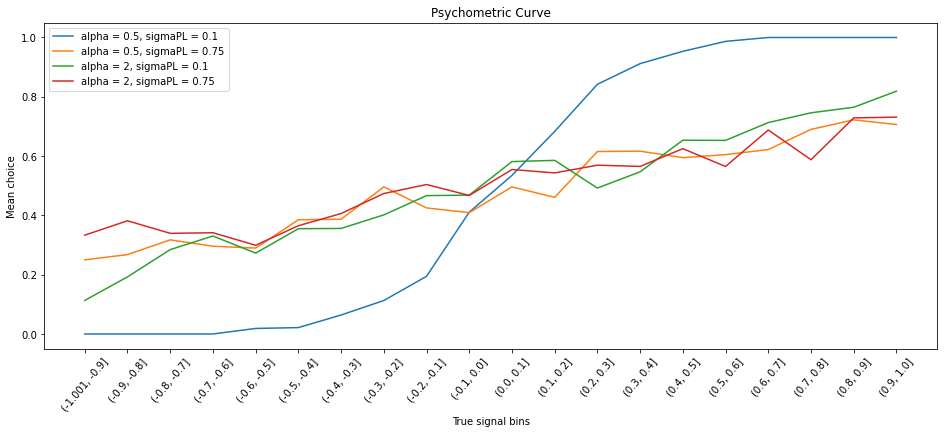

In [11]:
make_psychometrics(alphas_list = [0.5, 2], sigmas_list = [0.1, 0.75], n = 2500, split_prevF=False)

Model run with alpha = 0.5, sigmaPL = 0.1, n = 2500. Completed in: 6.93 sec
Model run with alpha = 2, sigmaPL = 0.1, n = 2500. Completed in: 6.83 sec
Whole process completed in: 13.91 sec


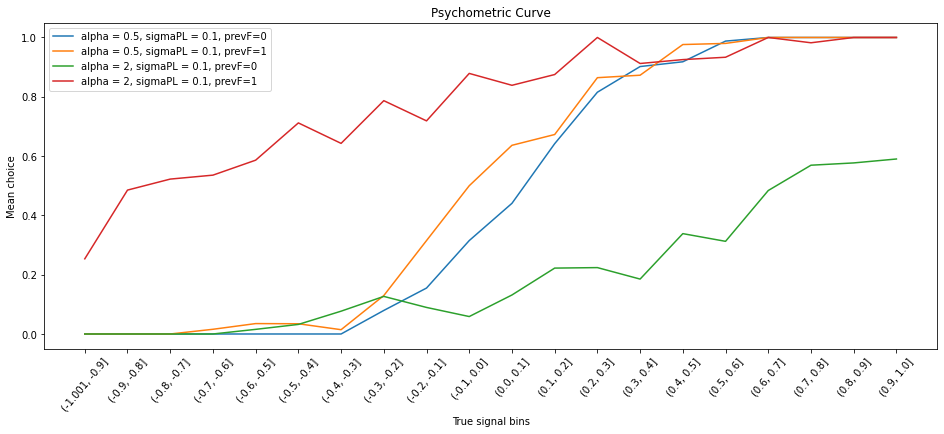

In [12]:
make_psychometrics(alphas_list = [0.5, 2], sigmas_list = [0.1], n = 2500, split_prevF=True)

Model run with alpha = 1, sigmaPL = 0.1, n = 2500. Completed in: 7.9 sec
Model run with alpha = 1, sigmaPL = 0.75, n = 2500. Completed in: 8.27 sec
Whole process completed in: 16.33 sec


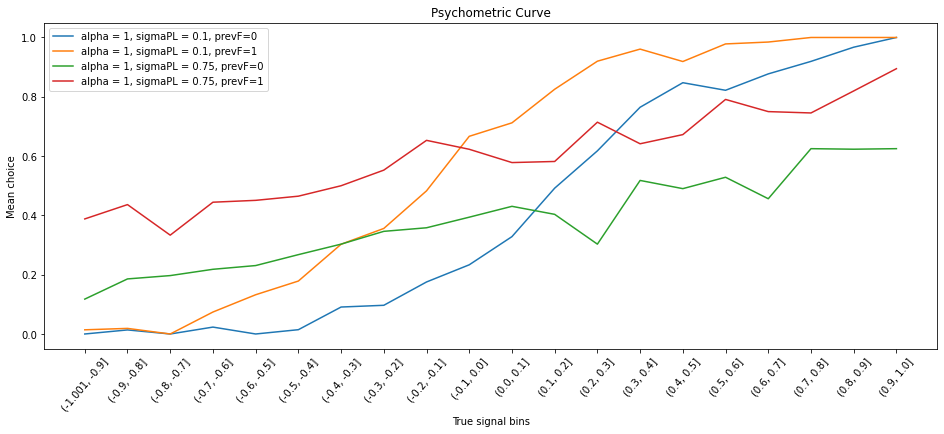

In [13]:
make_psychometrics(alphas_list = [1], sigmas_list = [0.1, 0.75], n = 2500, split_prevF=True)

Model run with alpha = 1, sigmaPL = 0.1, n = 1000. Completed in: 3.36 sec
Model run with alpha = 1, sigmaPL = 0.5, n = 1000. Completed in: 3.39 sec


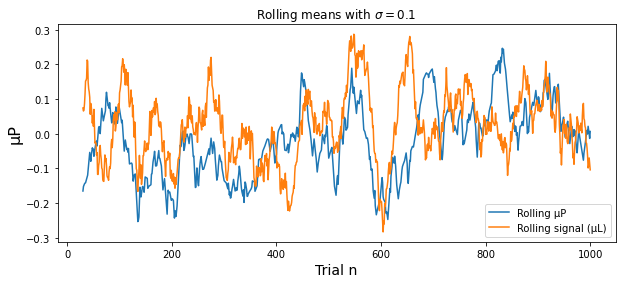

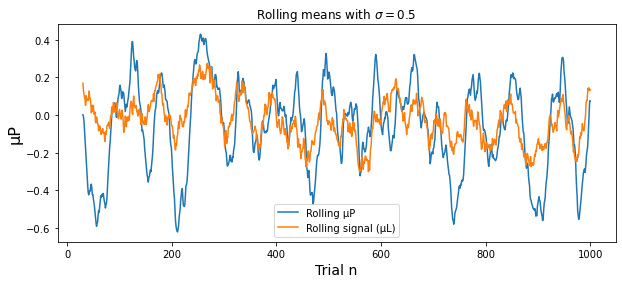

In [14]:
# Rolling means of signal and µP

df = run_model(n=1000, sigmaPL = 0.1)

rolling_muP = df["old_muP"].rolling(30).mean()

rolling_muL = df["muL"].rolling(30).mean()

plt.figure(figsize=(10,4))

plt.plot(rolling_muP, label = "Rolling µP")
plt.plot(rolling_muL, label = "Rolling signal (µL)")

plt.title("Rolling means with $\sigma =$" + str(0.1))
plt.xlabel("Trial n", fontsize = 14)
plt.ylabel("µP", fontsize = 16, rotation=90)

plt.legend()

##

df = run_model(n=1000, sigmaPL = 0.5)

rolling_muP = df["old_muP"].rolling(30).mean()

rolling_muL = df["muL"].rolling(30).mean()

plt.figure(figsize=(10,4))

plt.plot(rolling_muP, label = "Rolling µP")
plt.plot(rolling_muL, label = "Rolling signal (µL)")

plt.title("Rolling means with $\sigma =$" + str(0.5))
plt.xlabel("Trial n", fontsize = 14)
plt.ylabel("µP", fontsize = 16, rotation=90)

plt.legend()

In [15]:
def plot_vevaiometrics(final_table):
    
    # plot psychometric curves from single final table
    ax = final_table.plot.line(figsize=(16,6))

    ax.set_xlabel('True signal bins')
    ax.set_ylabel('Mean confidence')

    ax.set_title("Vevaiometric Curve")

    ax.set_xticks(range(len(final_table.index)))
    ax.set_xticklabels(final_table.index, rotation=50)

    None # omit matplotlib text output

In [16]:
def make_bins_confidence(model_df, column_name_str, data):
    
    """Adds bins to model_df, calculates mean confidence for each bin.
    Adds means to data dictionary. Returns bins."""
    
    bins_array = np.arange(-10, 11, 1)/10 # make bins from -1 to +1 with steps of 0.1
    bin_list = bins_array.tolist()
    
    model_df = model_df.assign(signal_bins = pd.cut(model_df.muL, bins=bin_list, right=True, include_lowest=True))

    bins_to_mean = {} # dictionary mapping bins to mean confidence

    bins = model_df.signal_bins.values.categories.values

    for Bin in bins:
        fancy_idx = model_df["signal_bins"] == Bin
        bin_average = model_df[fancy_idx]["c"].mean()
        #print("\n", "bin_average = ", bin_average)
        bins_to_mean[Bin] = bin_average

    values = list(bins_to_mean.values())
    #print("\n", "values =", values)

    data[column_name_str] = values # updates dictionary with columns denoting alphas and sigmas
    #print("\n", "data =", data)
    
    return bins

In [17]:
def split_df_confidence(df):
    
    """Splits df into a df with choice=False and a df with choice=True"""
    
    idx_correct_choice = df["correct_choice"] == True
    idx_incorrect_choice = df["correct_choice"] == False

    correct = df[idx_correct_choice]
    incorrect = df[idx_incorrect_choice]

    return pd.Series([correct, incorrect], index=["Correct", "Incorrect"])

In [18]:
def make_vevaiometrics(alphas_list, sigmas_list, n, split_choice=False):
    
    """ Function to plot several psychometric curves. 
    Takes a list of alpha values, a list of sigma (sd of likelihood and prior) values,
    and a number of trials n for each curve. If split_choice=True, plots for Correct and Incorrect trials separately. """
    
    start_time = timeit.default_timer()
    
    global final_df
    
    data = {} # to be made into final_df
    
    for alpha in alphas_list:

        for sigma in sigmas_list:
            
            model_df = run_model(sigmaPL=sigma, alpha=alpha, n=n, plot=False) # run model, create df
            
            if not split_choice:
                
                column_name_str = "alpha = " + str(alpha) + ", sigma = " + str(sigma)
                bins = make_bins_confidence(model_df, column_name_str, data)
            
            else: # split into Correct and Incorrect choices
                
                split_bin_start_time = timeit.default_timer()
                
                dfs = split_df_confidence(model_df) # creates pd.Series with two DataFrames, one for Correct, one for Incorrect
                
                for idx in dfs.index:
                    #print("\n", "str(idx):", "\n", str(idx))
                    #print("\n", "dfx[idx]:", "\n", dfs[idx])
                    
                    column_name_str = "alpha = " + str(alpha) + ", sigma = " + str(sigma) + ", " + str(idx)
                    bins = make_bins_confidence(dfs[idx], column_name_str, data)
                
    final_df = pd.DataFrame(data, index=bins)

    plot_vevaiometrics(final_df) # plot psychometric curves from single final table
    
    elapsed = timeit.default_timer() - start_time
    
    print("Whole process completed in:", round(elapsed, 2), "sec")

Model run with alpha = 1, sigmaPL = 0.1, n = 20000. Completed in: 62.78 sec
Whole process completed in: 62.88 sec


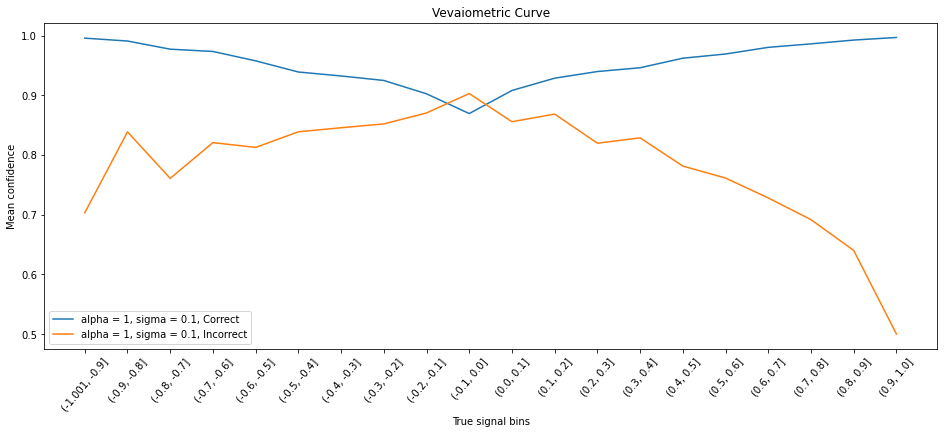

In [19]:
make_vevaiometrics(alphas_list = [1], sigmas_list = [0.1], n = 20000, split_choice=True)